In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=1,
                threads_per_worker=4,
                memory_limit='16GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58933,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:58938,Total threads: 4
Dashboard: http://127.0.0.1:58939/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:58936,


In [3]:
import copy
import sys
import xarray as xr
import numpy as np
import dask.array as da
import time
import os

import dask

import matplotlib.pyplot as plt
import hvplot.xarray
import holoviews as hv
import scipy.constants
import scipy

sys.path.append("../..")
import processing_dask as pr
import plot_dask

sys.path.append("../../../preprocessing/")
from generate_chirp import generate_chirp

/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#prefix = "/media/thomas/Extreme SSD/orca_paper_data_files/phase_noise/b205/20240222_203345"

#prefix = "/Volumes/Extreme SSD/orca_paper/20240226_105437" # no phase dithering, no LO offset
#prefix = "/Volumes/Extreme SSD/orca_paper/20240226_105916" # yes phase dithering, no LO offset
#prefix = "/Volumes/Extreme SSD/orca_paper/20240226_110410" # no phase dithering, software LO offset of 12.5 MHz
prefix = "/Volumes/Extreme SSD/orca_paper/20240226_110948" # yes phase dithering, software LO offset of 12.5 MHz

zero_sample_idx = 63 # X310, fs = 50 MHz
#zero_sample_idx = 159

dielectric_constant = 2.2957 # ice (air = 1, 66% velocity coax = 2.2957)
sig_speed = scipy.constants.c / np.sqrt(dielectric_constant)

zarr_path = pr.save_radar_data_to_zarr(prefix)

zarr_path

'/Volumes/Extreme SSD/orca_paper/20240226_110948.zarr'

In [5]:
raw = xr.open_zarr(zarr_path)

In [ ]:
chirp_ts, chirp = generate_chirp(raw.config)

compressed = pr.pulse_compress(raw, chirp,
                               fs=raw.config['GENERATE']['sample_rate'],
                               zero_sample_idx=zero_sample_idx,
                               signal_speed=sig_speed).persist()

In [ ]:
# save pulse compressed data to location
zarr_base_location = "/Volumes/Extreme SSD/orca_paper/"
compressed_zarr_path = os.path.join(zarr_base_location, raw.basename + "_pulsecompressed.zarr")
print("Writing pulse compressed data to: ", compressed_zarr_path)

compressed.to_zarr(compressed_zarr_path, mode='w')

In [6]:
compressed = xr.open_zarr("/Volumes/Extreme SSD/orca_paper/20240226_110948_pulsecompressed.zarr")

In [7]:
stacks = [1, 10, 100, 1000, 10000, 100000, 1000000]
ts = stacks

noise_start_distance_1way = 1000 # m

## Noise Floor Variance

In [8]:
actual_stack_t = np.nan * np.zeros_like(ts)
actual_stack_n = np.zeros_like(ts, dtype=int)

# Statistics to compute
stack_noise_var = np.nan * np.zeros_like(ts)
stack_noise_mean = np.nan * np.zeros_like(ts)

In [9]:
for t_idx, t in enumerate(ts):
    if not np.isnan(stack_noise_mean[t_idx]):
        continue # Skip if already computed (in case of interruption and restart)
    
    timestamp = time.time() # Track computation time 

    actual_stack_n[t_idx] = t
    actual_stack_t[t_idx] = actual_stack_n[t_idx] * raw.attrs['config']['CHIRP']['pulse_rep_int'] # TODO: Account for errors?
    print(f"[{t_idx+1}/{len(ts)}] \tt={actual_stack_t[t_idx]} \tn_stack={actual_stack_n[t_idx]}")
    
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):

        stacked = pr.stack(compressed, actual_stack_n[t_idx])
        compressed_pwr = xr.apply_ufunc(lambda x: np.abs(x)**2, stacked, dask='parallelized').chunk("auto")
        
        noise_pwr = compressed_pwr["radar_data"].where((compressed_pwr.reflection_distance > noise_start_distance_1way)).dropna('travel_time').chunk("auto")
        
        stack_noise_var[t_idx] = noise_pwr.var(dim="travel_time").mean().compute().item()
        stack_noise_mean[t_idx] = noise_pwr.mean().compute().item()

        
    print(f"Completed in {time.time() - timestamp} seconds from {len(noise_pwr)} stacked pulses")

[1/7] 	t=0.0002 	n_stack=1


/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Completed in 260.97286200523376 seconds from 1000000 stacked pulses
[2/7] 	t=0.002 	n_stack=10


/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 303.92903304100037 seconds from 100000 stacked pulses
[3/7] 	t=0.02 	n_stack=100


/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 245.15665102005005 seconds from 10000 stacked pulses
[4/7] 	t=0.2 	n_stack=1000


/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 109.0125379562378 seconds from 1000 stacked pulses
[5/7] 	t=2.0 	n_stack=10000


/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 82.54411888122559 seconds from 100 stacked pulses
[6/7] 	t=20.0 	n_stack=100000


/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 99.91043472290039 seconds from 10 stacked pulses
[7/7] 	t=200.0 	n_stack=1000000


/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 505.6961269378662 seconds from 1 stacked pulses


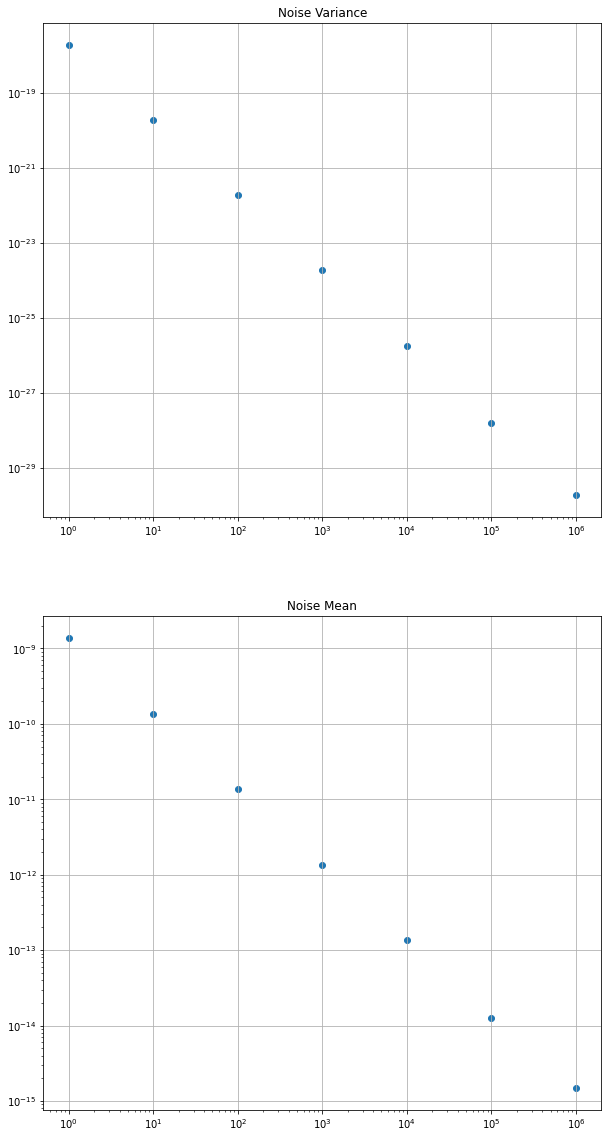

In [10]:
fig, (ax_noise_var, ax_noise_mean) = plt.subplots(2, 1, figsize=(10, 20))

ax_noise_var.scatter(actual_stack_n, stack_noise_var)
ax_noise_var.set_title("Noise Variance")
ax_noise_var.loglog()
ax_noise_var.grid()

ax_noise_mean.scatter(actual_stack_n, stack_noise_mean)
ax_noise_mean.set_title("Noise Mean")
ax_noise_mean.loglog()
ax_noise_mean.grid()

In [11]:
import pickle
with open(f"outputs/{raw.basename}-noise-stats.pickle", "wb") as f:
    pickle.dump({'n_stacks': actual_stack_n, 'stack_times': actual_stack_t, 'stack_noise_var': stack_noise_var, 'stack_noise_mean': stack_noise_mean, 'prefix': raw.prefix}, f)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
ax_pwr, ax_ph = axs

ax_pwr.plot(actual_stack_t, stack_signal_peak_pwr_mean)
# Add a shaded region for the variance
ax_pwr.fill_between(actual_stack_t, stack_signal_peak_pwr_mean - np.sqrt(stack_signal_peak_pwr_variance),
                    stack_signal_peak_pwr_mean + np.sqrt(stack_signal_peak_pwr_variance), alpha=0.4)
ax_pwr.set_title("Signal Power")
ax_pwr.loglog()

ax_ph.plot(actual_stack_t, stack_signal_peak_phase)
# Add a shaded region for the variance
ax_ph.fill_between(actual_stack_t, stack_signal_peak_phase - np.sqrt(stack_signal_peak_phase_variance),
                    stack_signal_peak_phase + np.sqrt(stack_signal_peak_phase_variance), alpha=0.4)
ax_ph.set_title("Signal Phase")
ax_ph.semilogx()

for ax in axs:
    ax.grid(True)

plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.loglog()
ax.scatter(actual_stack_n, stack_noise_var)
ax.set_xlabel('n_stack')
ax.set_ylabel('Variance of noise floor (2-4km)')
ax.set_title(f"pulse_rep_int = {raw.attrs['config']['CHIRP']['pulse_rep_int']} s")
plt.grid()
#fig.savefig(output_base_stack + ".png")

## Signal peak phase

In [ ]:
# Signal
reflector_distance_expected = 25
expected_peak_idx = (np.abs(compressed.reflection_distance - reflector_distance_expected)).argmin().item()

peak_idxs = compressed["radar_data"].reduce(
    lambda x, axis: (np.abs((x[:, expected_peak_idx-5:expected_peak_idx+5]))).argmax(axis=axis) + expected_peak_idx-5,
    dim='travel_time')
peak_idxs.persist()
true_peak_idx = peak_idxs[0].compute().item()
if not (peak_idxs == true_peak_idx).all().compute().item():
    print("WARNING: Peak indices are not all the same!")

In [ ]:
expected_internal_path_idx = (np.abs(compressed.reflection_distance)).argmin().item()
expected_internal_path_idx

In [ ]:
peak_phases = xr.apply_ufunc(
        lambda x, idx: np.angle(x[idx]),
        compressed["radar_data"], peak_idxs,
        input_core_dims=[['travel_time'],[]], # The dimension operated over -- aka "don't vectorize over this"
        output_core_dims=[[]], # The output dimensions of the lambda function itself
        exclude_dims=set(("travel_time",)), # Dimensions to not vectorize over
        vectorize=True, # Vectorize other dimensions using a call to np.vectorize
        dask="parallelized", # Allow dask to chunk and parallelize the computation
        output_dtypes=[np.float32], # Needed for dask: explicitly provide the output dtype
        #dask_gufunc_kwargs={"output_sizes": {'travel_time': 1}} # Also needed for dask:
        # explicitly provide the output size of the lambda function. See
        # https://docs.dask.org/en/stable/generated/dask.array.gufunc.apply_gufunc.html
    ).persist()

In [ ]:
fs = raw.attrs['config']['GENERATE']['sample_rate']

actual_dt = np.zeros_like(ts)
var = np.zeros_like(ts)

for t_idx, t in enumerate(ts):
    print(f"[{t_idx}/{len(ts)}] \tt={t}")
    pulses = max(1, int(t / raw.attrs['config']['CHIRP']['pulse_rep_int']))
    actual_dt[t_idx] = pulses * raw.attrs['config']['CHIRP']['pulse_rep_int']
    ph_group_mean = peak_phases.rolling(pulse_idx=pulses).mean()
    var[t_idx] = ((ph_group_mean[:-pulses].drop_indexes("pulse_idx") - ph_group_mean[pulses:].drop_indexes("pulse_idx"))**2).mean().compute().item()

In [ ]:
output_base_2svar = os.path.join("20230628-outputs/", raw.attrs["basename"]+"-2svar")

d = xr.Dataset({"var_2s": ("dt", var)}, coords={"dt": actual_dt})
d.to_netcdf(output_base_2svar + ".nc")

In [ ]:
fig, ax = plt.subplots()
ax.loglog()
ax.scatter(actual_dt, var)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Two sample phase variance')
ax.set_title(f"pulse_rep_int = {raw.attrs['config']['CHIRP']['pulse_rep_int']} s")
plt.grid()
fig.savefig(output_base_2svar + ".png")

In [ ]:
output_base_phase = os.path.join("20230628-outputs/", raw.attrs["basename"]+"-phase")

peak_idx_plot = peak_idxs.hvplot.scatter(x='pulse_idx')
peak_phase_plot = peak_phases.hvplot.scatter(x='pulse_idx', datashade=True)
peak_phase_rolling_plot = peak_phases.rolling(pulse_idx=100).mean().hvplot.scatter(x='pulse_idx', datashade=True)

In [ ]:
hv.save(peak_idx_plot, output_base_phase+"-peak-idx.png", fmt='png')
hv.save(peak_phase_plot, output_base_phase+"-peak-phase.png", fmt='png')
hv.save(peak_phase_rolling_plot, output_base_phase+"-peak-phase-rolling.png", fmt='png')

hv.save(peak_idx_plot, output_base_phase+"-peak-idx.html", fmt='widgets')
hv.save(peak_phase_plot, output_base_phase+"-peak-phase.html", fmt='widgets')
hv.save(peak_phase_rolling_plot, output_base_phase+"-peak-phase-rolling.html", fmt='widgets')

peak_idx_plot, peak_phase_plot, peak_phase_rolling_plot